In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
from scipy.sparse import csgraph

In [2]:
N_TRIAL = 30000
N_ARMS = 100
N_FEATURE = 3
M = 33
np.random.seed(123)

In [3]:
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Beta = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Beta(noise_rsc2).csv',delimiter=',')
# X_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/X.csv',delimiter=',')
Y_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Y(noise_rsc2).csv',delimiter=',')
W = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/W(noise_rsc2).csv',delimiter=',')

Mounted at /content/drive


In [4]:
# create X
X_1_lst = []
for T in np.arange(N_TRIAL):
  X_1t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_1t_lst.append(np.array(temp))
    # np.append(X_1, X_1t)
  X_1_lst.append(np.array(X_1t_lst))
X_1 = np.array(X_1_lst)

In [5]:
oracle_lst = []
true_choice = []
new_y = -1 * Y_1 + 30
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [new_y.T[t, arm] for arm in np.arange(N_ARMS)]
  chosen_arms = np.array(all_reward_t).argsort()[-M:][::-1]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([new_y.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
  true_choice.append(chosen_arms)
  # if (t+1) % 3000 == 0:
  #   print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
oracle_case1 = np.array(oracle_lst)

In [6]:
# Create the Adj matrix
def constructAdjMatrix(W, n, threshold): #m
    Adj_mat = np.zeros(shape = (n, n))
    for ui in range(n):
        for uj in range(n):
            Adj_mat[ui][uj] = W[ui][uj]
        # find out the top M similar users in G -> find a threshold
#         if m>0 and m<n:
#             similarity = sorted(W[ui], reverse=True)
#             threshold = similarity[m]
        # trim the graph
            for i in range(n):
                if W[ui][i] <= threshold:
                    Adj_mat[ui][i] = 0;
        Adj_mat[ui] /= sum(Adj_mat[ui])
    return Adj_mat

# Create the laplacian matrix
def constructLaplacianMatrix(W, n, Gepsilon):
    G = W.copy()
    #Convert adjacency matrix of weighted graph to adjacency matrix of unweighted graph
    for i in range(n):
        for j in range(n):
            if G[i][j] > 0:
                G[i][j] = 1
    L = csgraph.laplacian(G, normed = False)
    I = np.identity(n = G.shape[0])
    GW = I + Gepsilon*L  # W is a double stochastic matrix
    return GW.T

In [7]:
# convert to a sparse matrix -> convert to a long sparse vector with flatten()
def X_to_X_m(X, t, arm_choice, n_arms, n_feature): 
  X_m = np.copy(X[t])
  for arm in np.arange(n_arms): # N x p
    if arm not in arm_choice:
      X_m[arm] = np.zeros(shape=n_feature)
  return X_m

In [8]:
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

In [9]:
def plot_l2_norm_diff(results, true_theta, n_trial, n_arms, n_feature, FInv_Init):
    [plt.plot(make_l2_norm_diff(x['theta_lst'], true_theta, n_trial, n_arms, n_feature, FInv_Init), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

#normalized l2_norm_diff
def make_l2_norm_diff(theta, true_theta, n_trial, n_arms, n_feature, FInv_Init):
    diff = []
    for t in range(n_trial):
        theta_matrix = (FInv_Init.dot(theta[t])).reshape(n_arms, n_feature) #with FInv_Init
#         theta_matrix = theta[t].reshape(n_arms, n_feature) #without FInv_Init
        diff_t = 0
        for arm in range(n_arms):
            diff_vec = theta_matrix[arm] - (-true_theta[arm])
            diff_t += np.linalg.norm(diff_vec, ord=2)
        diff.append(diff_t)
        # show the difference every 3000 iterations
#         if (t+1) % 1000 == 0:
#             print('TRIAL:', t+1 , 'diff:', diff_t)
    return np.array(diff)

In [10]:
def GOBLin(alpha, eta, X, Y, m, FInv, oracle, min_cregret, true_choice):
    print("GOB.Lin with alpha: ", alpha)
    n_trial, n_arms, n_feature = X.shape
    
    # 1.1.output object
    r_payoff = np.empty(n_trial)
    c_payoff = np.empty(n_trial)
    cum_regret = np.empty(n_trial)
    t_break = 0
    final_c_regret = 100000
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    p = np.empty(shape=(n_trial, n_arms))
    acc = np.empty(shape=(n_trial, n_arms))

    pred_reward = np.empty(shape=(n_trial, n_arms)) 
    ucb = np.empty(shape=(n_trial, n_arms))
    selected_pred = np.empty(n_trial)
    opt_pred = np.empty(n_trial)  
    selected_err = np.empty(n_trial)
    opt_err = np.empty(n_trial)
    opt_payoff = np.empty(n_trial)
    mse_sel = np.empty(n_trial)
    mse_opt = np.empty(n_trial)
    # 1.2. A and b

    A = eta * np.identity(n = n_feature * n_arms)   #dn x dn
    b = np.zeros(shape=n_feature * n_arms)        #dn x 1
    inv_A = np.linalg.inv(A)
    theta_lst = np.empty(shape=(n_trial, n_arms *  n_feature))
    theta = np.dot(inv_A, b)
    
    # 2. Algorithm
      # theta = w
      # A = M
      # b = b
      # p_t = k_t
    for t in np.arange(n_trial):
        
        #Compute estimates (theta) and prediction (p) for all arms
        for a in np.arange(n_arms):
            X_1_tr = FInv.dot((X_to_X_m(X, t, [a], n_arms, n_feature)).flatten())
            pred_reward[t, a] = theta.dot(X_1_tr)
            ucb[t, a] = alpha * np.sqrt(np.dot(np.dot(X_1_tr, inv_A), X_1_tr))
            p[t, a] =  pred_reward[t,a] + ucb[t,a] 
            #acc[t, a]   = p[t, a] - Y[t, a]
        # Choose m best arms
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_arms = idx[np.argsort(-(p[t])[idx])]
        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        #selected_pred[t] = sum([pred_reward[t, a] for a in chosen_arms])
        #opt_pred[t] = sum([pred_reward[t, a] for a in true_choice[t]])

        #update A and b
        for chosen_arm in arm_choice[t]:
          X_1_tr_chosen = FInv.dot((X_to_X_m(X, t, [chosen_arm], n_arms, n_feature)).flatten())
          A = A + np.outer(X_1_tr_chosen, X_1_tr_chosen)
          b = b + Y[t, chosen_arm] * X_1_tr_chosen
        inv_A = np.linalg.inv(A)
        theta = inv_A.dot(b)
        theta_lst[t] = theta
        
        # Cumulative rewards
        if t == 0:
            c_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        else:
            c_payoff[t]   = c_payoff[t-1] + np.sum([Y[t, choice] for choice in arm_choice[t]])
        r_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        
        cum_regret[t] = np.sum(oracle[0:t+1] - r_payoff[0:t+1])

        #opt_payoff[t] = np.sum([Y[t, choice] for choice in true_choice[t]])
        #selected_err[t] = selected_pred[t] - r_payoff[t]
        #opt_err[t] = opt_pred[t] - opt_payoff[t]

        mse_sel[t] = sum(np.square(pred_reward[t, a] - Y[t, a]) for a in chosen_arms)/m
        mse_opt[t] = sum(np.square(pred_reward[t, a] - Y[t, a]) for a in true_choice[t])/m

        if cum_regret[t] > min_cregret:
            print('break at trial:', t, 'with cum_regret:', cum_regret[t])
            break
        if (t+1) % 10000 == 0:
            print('TRIAL:',t,'DONE', '| cum_regret:', cum_regret[t])
            # t_break = t
        if t+1 == 30000:
            t_break = n_trial
            final_c_regret = cum_regret[t]
        # show the selected arms every 100 iterations
        # if (t+1) % 1000 == 0:
        #     print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)

    return dict(mse_sel=mse_sel, mse_opt=mse_opt, theta=theta, theta_lst=theta_lst, p=p, arm_choice = arm_choice, r_payoff=r_payoff, A=A, c_payoff=c_payoff, acc=acc, t_break=t_break, final_c_regret = final_c_regret, alpha = alpha, selected_err=selected_err, opt_err=opt_err)

In [11]:

# lda_lst
lda_lst = [1] 
T = 0.5
# set min_target_cregret
min_target_cregret = 5000
alpha = 888
rec_alpha = 888
rec_lda = 888
for l in lda_lst:
  # Create the F matrix
  lda = l
  test_adj = constructAdjMatrix(W, N_ARMS, T)
  test_F = constructLaplacianMatrix(test_adj, N_ARMS, lda)
  F_kron = np.kron(test_F, np.identity(n=N_FEATURE))
  FInv_Init = sqrtm(np.linalg.inv(np.kron(test_F, np.identity(n=N_FEATURE))))

  # Run GOB.Lin
  print('---------------------------------------------------------------------------')
  print('M:', M, 'lda:', lda, 'T', T)
  results_dict = {}
  alpha_to_test = [0.5,0.7]
  for alpha in alpha_to_test:
    results_dict[alpha] = GOBLin(min_cregret = min_target_cregret, alpha = alpha, eta = 0.3, X=X_1, Y=(-1 * Y_1 + 30).T, m=M, FInv=FInv_Init, oracle=oracle_case1, true_choice=true_choice)
    if results_dict[alpha]['t_break'] == 30000:
      if results_dict[alpha]['final_c_regret'] < min_target_cregret:
        # min_target_cregret = results_dict[alpha]['final_c_regret']
        rec_alpha = results_dict[alpha]['alpha']
        rec_lda = l
  print('M:', M, 'lda:', lda, 'T', T)
  print('min cum regret:', min_target_cregret, 'alpha:', rec_alpha, 'lda:', rec_lda)
  print('---------------------------------------------------------------------------')

---------------------------------------------------------------------------
M: 33 lda: 1 T 0.5
GOB.Lin with alpha:  0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: ComplexWarning: Casting complex values to real discards the imaginary part


TRIAL: 9999 DONE | cum_regret: 2862.4235681387127
TRIAL: 19999 DONE | cum_regret: 2916.0191404780394
TRIAL: 29999 DONE | cum_regret: 2916.300797552593
GOB.Lin with alpha:  0.7
TRIAL: 9999 DONE | cum_regret: 2703.1650159685278
TRIAL: 19999 DONE | cum_regret: 2936.8083025811216
TRIAL: 29999 DONE | cum_regret: 2983.169599080728
M: 33 lda: 1 T 0.5
min cum regret: 5000 alpha: 0.7 lda: 1
---------------------------------------------------------------------------


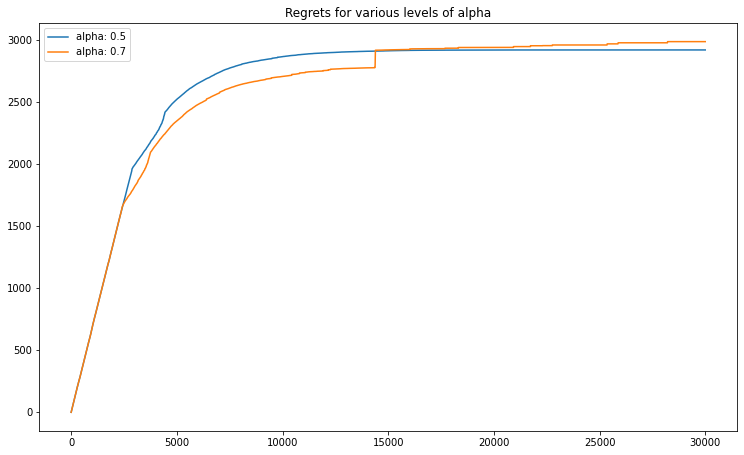

In [12]:
# Plot regrets
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
# plt.plot(make_regret(payoff=payoff_random, oracle=oracle_case1), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

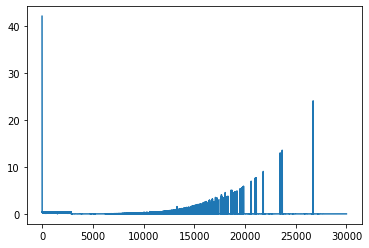

In [13]:
plt.plot(results_dict[0.5]['mse_opt'])

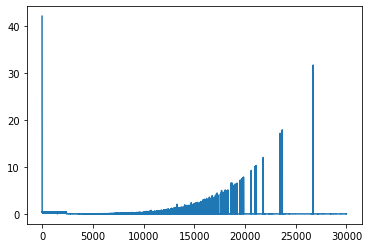

In [18]:
plt.plot(results_dict[0.7]['mse_opt'])

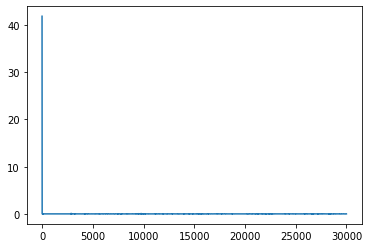

In [14]:
plt.plot(np.abs(results_dict[0.5]['mse_sel']))

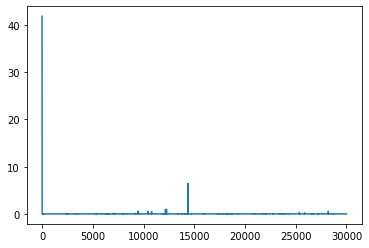

In [19]:
plt.plot(results_dict[0.7]['mse_sel'])

In [15]:
from google.colab import files
# test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
# df2 = pd.DataFrame(test_lst[0])
# df2.to_csv('C1_GOBLin_regret_66_rsc2.csv', header=False)
# files.download('C1_GOBLin_regret_66_rsc2.csv')

In [16]:
from google.colab import files
# sel_err_lst = results_dict[0.25]['selected_err']
# df_s = pd.DataFrame(sel_err_lst)
# df_s.to_csv('C1_GOBLin_sel_err_66_rsc2.csv', header=False)
# files.download('C1_GOBLin_sel_err_66_rsc2.csv')
# opt_err_lst = results_dict[0.25]['opt_err']
# df_o = pd.DataFrame(opt_err_lst)
# df_o.to_csv('C1_GOBLin_opt_err_66_rsc2.csv', header=False)
# files.download('C1_GOBLin_opt_err_66_rsc2.csv')

In [17]:
# def GOBLin(alpha, eta, lda, X, Y, m, E):
#     print("GOB.Lin with alpha: ", alpha)
#     n_trial, n_arms, n_feature = X.shape
    
#     # 1.1.output object
#     r_payoff = np.empty(n_trial)
#     arm_choice = np.empty(shape=(n_trial, m), dtype=int)
#     p = np.empty(shape=(n_trial, n_arms))
#     acc = np.empty(shape=(n_trial, n_arms))
# #     F = np.identity(n=n_arms) + lda * E
# #     F_kron = np.kron(F, np.identity(n=n_feature))
# #     FInv = sqrtm(np.linalg.inv(np.kron(F, np.identity(n=n_feature))))
# #     F_sqrt = sqrtm(np.kron(F, np.identity(n=n_feature)))
#     FInv = E
#     # 1.2. A and b

#     A = eta * np.identity(n = n_feature * n_arms)   #dn x dn
#     b = np.zeros(shape=n_feature * n_arms)        #dn x 1
#     inv_A = np.linalg.inv(A)
#     theta_lst = np.empty(shape=(n_trial, n_arms *  n_feature))
#     theta = np.dot(inv_A, b)
    
#     # 2. Algorithm
#       # theta = w
#       # A = M
#       # b = b
#       # p_t = k_t
#     for t in np.arange(n_trial):
        
#         #Compute estimates (theta) and prediction (p) for all arms
#         for a in np.arange(n_arms):
#             X_1_tr = FInv.dot((X_to_X_m(X, t, [a], n_arms, n_feature)).flatten())
#             p[t, a] = theta.dot(X_1_tr) + alpha * np.sqrt(np.dot(np.dot(X_1_tr, inv_A), X_1_tr)) #.clip(0))
#             acc[t, a]   = p[t, a] - Y[t, a]
#         # Choose m best arms
# #         idx = np.argpartition(p[t], -m)[-m:]
# #         chosen_arms = idx[np.argsort((-p[t])[idx])]
#         idx = np.argpartition(p[t], -m)[-m:]
#         chosen_arms = idx[np.argsort(-(p[t])[idx])]
# #         chosen_arms = p[t].argsort()[-m:][::-1]
#         for i in np.arange(m):
#           arm_choice[t][i] = chosen_arms[i]
        
#         #update A and b
#         for chosen_arm in arm_choice[t]:
#           X_1_tr_chosen = FInv.dot((X_to_X_m(X_1, t, [chosen_arm], n_arms, n_feature)).flatten())
#           A = A + np.outer(X_1_tr_chosen, X_1_tr_chosen)
#           b = b + Y[t, chosen_arm] * X_1_tr_chosen
#         inv_A = np.linalg.inv(A)
#         theta = inv_A.dot(b)
#         theta_lst[t] = theta
#         r_payoff[t]   = np.sum([Y[t, choice] for choice in arm_choice[t]])
        
#         # show the selected arms every 3000 iterations
#         if t % 3000 == 0:
#             print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
# #         print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
#     return dict(theta=theta, theta_lst=theta_lst, p=p, arm_choice = arm_choice, r_payoff=r_payoff, A=A, acc=acc)